In [1]:
import os
import random
import numpy as np
import tensorflow as tf
seed = 1
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import gensim
import pandas as pd
import gensim.downloader as api
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import InputLayer, Dense, Embedding, Conv1D, GlobalMaxPooling1D

In [4]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [5]:
def convert_to_sequence(questions):
    X = questions['Preprocessed_Question']
    cognitive_level = {"Knowledge": 0, "Comprehension": 1, "Application": 2, "Analysis": 3, "Synthesis": 4, "Evaluation": 5}
    questions["BT LEVEL"].replace(cognitive_level, inplace = True)
    y = questions['BT LEVEL'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.10, stratify = questions['BT LEVEL'], 
                                                         shuffle = True, random_state = 1)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    tokenizer = Tokenizer(oov_token ='<OOV>')
    tokenizer.fit_on_texts(X_train)
    vocab = tokenizer.word_index
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    max_que_len = max(len(x) for x in X_train_seq)
    
    padded_X_train_seq = pad_sequences(X_train_seq, maxlen = max_que_len, padding = 'post')
    padded_X_test_seq = pad_sequences(X_test_seq, maxlen = max_que_len, padding = 'post')
    
    return padded_X_train_seq, y_train, padded_X_test_seq, y_test, vocab, max_que_len

In [6]:
def get_embedding(vocab):
    embedding_model = api.load('fasttext-wiki-news-subwords-300')
    embeddings = np.zeros((len(vocab) + 1, 300))
    for word, index in vocab.items():
        if word in embedding_model.key_to_index:
            embedding_vector = embedding_model[word]
            embeddings[index] = embedding_vector
        else:
            print(word)
    return embeddings

In [7]:
def build_model(vocab_size, embedding_len, max_que_len, embeddings):
  
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = embedding_len, weights = [embeddings], 
                        input_length = max_que_len,  trainable = True))
    model.add(Conv1D(32, 5, activation ='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(6, activation ='softmax'))
    return model

In [8]:
def evaluate_model(model, X_test, y_test):
    pred = model.predict(X_test)
    predicted_classes = np.argmax(pred, axis = 1)
    true_classes = np.argmax(y_test, axis = 1)
    accuracy = accuracy_score(true_classes, predicted_classes)
    print(f"Accuracy: {accuracy}")
    f1_ = f1_score(true_classes, predicted_classes, average = 'weighted')
    print(f"F1 score: {f1_}")
    print(classification_report(true_classes, predicted_classes))

In [9]:
def plot_result(log_data): 
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['loss'], label ='train')
    plt.plot(log_data['val_loss'], label ='test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['accuracy'], label ='train')
    plt.plot(log_data['val_accuracy'], label ='test')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['f1_score'], label ='train')
    plt.plot(log_data['val_f1_score'], label ='test')
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [10]:
questions = pd.read_excel('preprocessing_result/preprocessing_result-fasttext.xlsx')
questions

,Question,Preprocessed_Question,BT LEVEL
0,"Suppose prices of two goods are constant, expl...",suppose price good constant explain what happe...,Comprehension
1,Explain the concept of price leadership observ...,explain concept price leadership observe condi...,Comprehension
2,Define profit. Briefly explain how accounting ...,define profit briefly explain how account prof...,Comprehension
3,Describe the assumptions of monopolistic compe...,describe assumption monopolistic competitive m...,Comprehension
4,Explain the meaning of the law of diminishing ...,explain mean law diminish marginal return brie...,Comprehension
...,...,...,...
2517,PEST and SWOT are popular strategy tools. Disc...,pest swot popular strategy tool discuss how to...,Application
2518,List the advantages and disadvantages of Publi...,list advantage disadvantage public offer,Knowledge
2519,Show your calculations for all THREE (3) optio...,show calculation option discuss which option p...,Analysis
2520,Currently the product life cycle for Apple iPo...,currently product life cycle apple ipod growth...,Evaluation


In [11]:
padded_X_train_seq, y_train, padded_X_test_seq, y_test, vocab, max_que_len = convert_to_sequence(questions)

In [12]:
embeddings_fasttext = get_embedding(vocab)
np.save('embedding/fasttext/embeddings.npy', embeddings_fasttext)

In [13]:
embeddings_fasttext = np.load('embedding/fasttext/embeddings.npy')

In [14]:
training_logger = CSVLogger('log/FastText/training.log', separator = ',', append = False)

In [15]:
#model
model = build_model(len(vocab) + 1, 300, max_que_len, embeddings_fasttext)
# compiling the model
model.compile(optimizer = 'RMSprop', loss='categorical_crossentropy', metrics= ['accuracy', tfa.metrics.F1Score(6, 'weighted')])
# printing summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 44, 300)           1114200   
                                                                 
 conv1d (Conv1D)             (None, 40, 32)            48032     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 1,162,430
Trainable params: 1,162,430
Non-trainable params: 0
_________________________________________________________________


In [16]:
# fit the model
model.fit(padded_X_train_seq, y_train, epochs = 50, batch_size = 8, validation_data = (padded_X_test_seq, y_test),
                                                                      callbacks = [training_logger], verbose = 1)
#saving the trained model
model.save('saved_models/FastText/EQCM.h5')

Epoch 1/50
284/284 [==============================] - 4s 10ms/step - loss: 1.3264 - accuracy: 0.5381 - f1_score: 0.4901 - val_loss: 0.9004 - val_accuracy: 0.7431 - val_f1_score: 0.7354
Epoch 2/50
284/284 [==============================] - 3s 9ms/step - loss: 0.6241 - accuracy: 0.8206 - f1_score: 0.8187 - val_loss: 0.6107 - val_accuracy: 0.8063 - val_f1_score: 0.8037
Epoch 3/50
284/284 [==============================] - 3s 10ms/step - loss: 0.3369 - accuracy: 0.9039 - f1_score: 0.9038 - val_loss: 0.5604 - val_accuracy: 0.8063 - val_f1_score: 0.8038
Epoch 4/50
284/284 [==============================] - 3s 10ms/step - loss: 0.1895 - accuracy: 0.9480 - f1_score: 0.9479 - val_loss: 0.5468 - val_accuracy: 0.8182 - val_f1_score: 0.8203
Epoch 5/50
284/284 [==============================] - 3s 10ms/step - loss: 0.1089 - accuracy: 0.9714 - f1_score: 0.9713 - val_loss: 0.6002 - val_accuracy: 0.7984 - val_f1_score: 0.7976
Epoch 6/50
284/284 [==============================] - 3s 10ms/step - loss: 0

In [17]:
log_data = pd.read_csv('log/FastText/training.log', sep = ',', engine = 'python')
log_data.head(50)

,epoch,accuracy,f1_score,loss,val_accuracy,val_f1_score,val_loss
0,0,0.538123,0.490051,1.326368e+00,0.743083,0.735365,0.900406
1,1,0.820626,0.818678,6.240968e-01,0.806324,0.803714,0.610688
2,2,0.903922,0.903766,3.369234e-01,0.806324,0.803780,0.560425
3,3,0.947995,0.947867,1.895115e-01,0.818182,0.820252,0.546803
4,4,0.971353,0.971339,1.088711e-01,0.798419,0.797594,0.600164
5,5,0.985015,0.985013,6.227533e-02,0.798419,0.797132,0.625950
6,6,0.990304,0.990313,3.657136e-02,0.782609,0.778897,0.714371
7,7,0.994271,0.994273,1.912575e-02,0.770751,0.766513,0.772630
8,8,0.996474,0.996477,1.051348e-02,0.782609,0.779669,0.820455
9,9,0.998678,0.998678,4.474920e-03,0.758893,0.755533,0.931941


In [18]:
log_data['val_accuracy'].describe()

count    50.000000
mean      0.769170
std       0.013808
min       0.743083
25%       0.762846
50%       0.766798
75%       0.770751
max       0.818182
Name: val_accuracy, dtype: float64

In [19]:
log_data['val_f1_score'].describe()

count    50.000000
mean      0.766838
std       0.014407
min       0.735365
25%       0.760340
50%       0.764614
75%       0.767275
max       0.820252
Name: val_f1_score, dtype: float64

In [20]:
model.load_weights("saved_models/FastText/EQCM.h5")
evaluate_model(model, padded_X_test_seq, y_test)

8/8 [==============================] - 0s 4ms/step
Accuracy: 0.7707509881422925
F1 score: 0.7692166134659557
              precision    recall  f1-score   support

           0       0.66      0.83      0.73        35
           1       0.82      0.83      0.82        96
           2       0.82      0.56      0.67        32
           3       0.80      0.80      0.80        30
           4       0.70      0.75      0.72        28
           5       0.79      0.72      0.75        32

    accuracy                           0.77       253
   macro avg       0.76      0.75      0.75       253
weighted avg       0.78      0.77      0.77       253



In [21]:
log_data[['val_accuracy']].idxmax() + 1

val_accuracy    4
dtype: int64

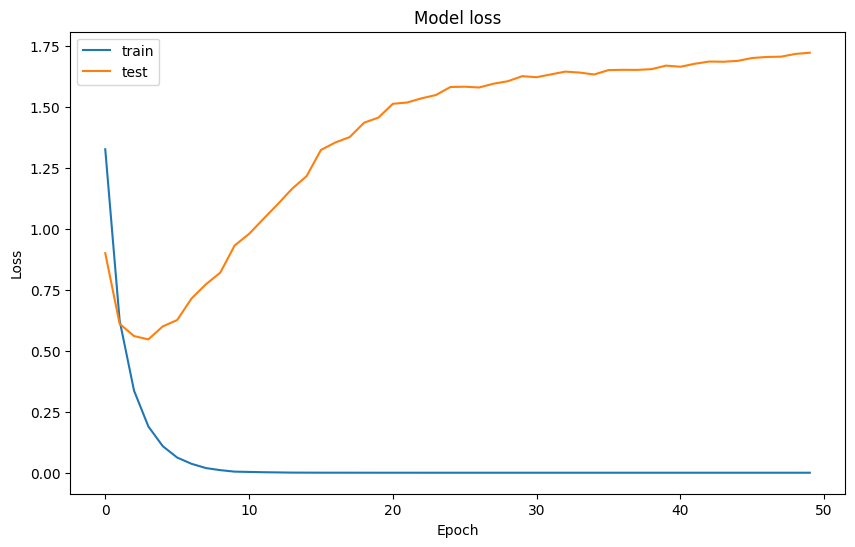

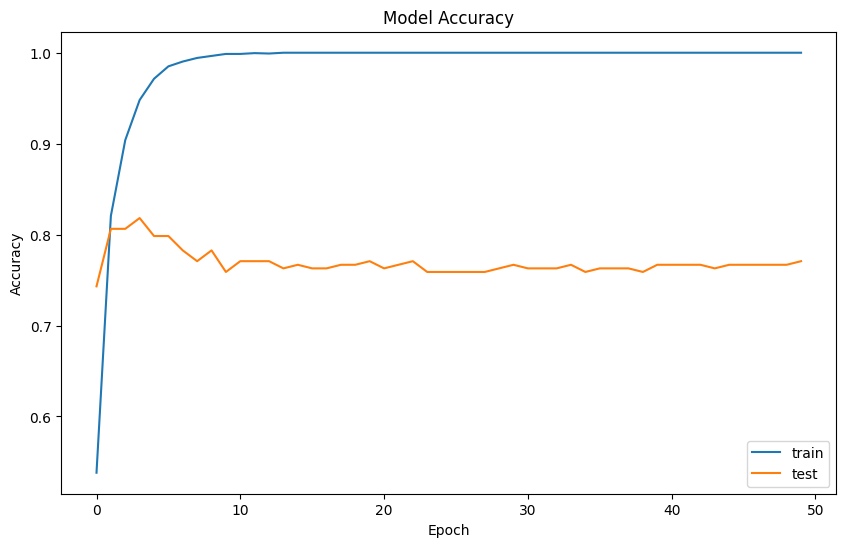

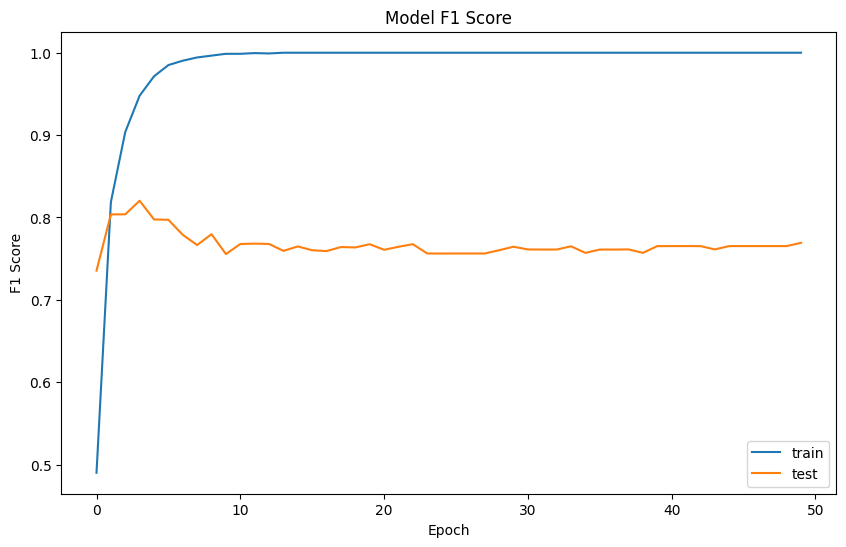

In [22]:
plot_result(log_data)

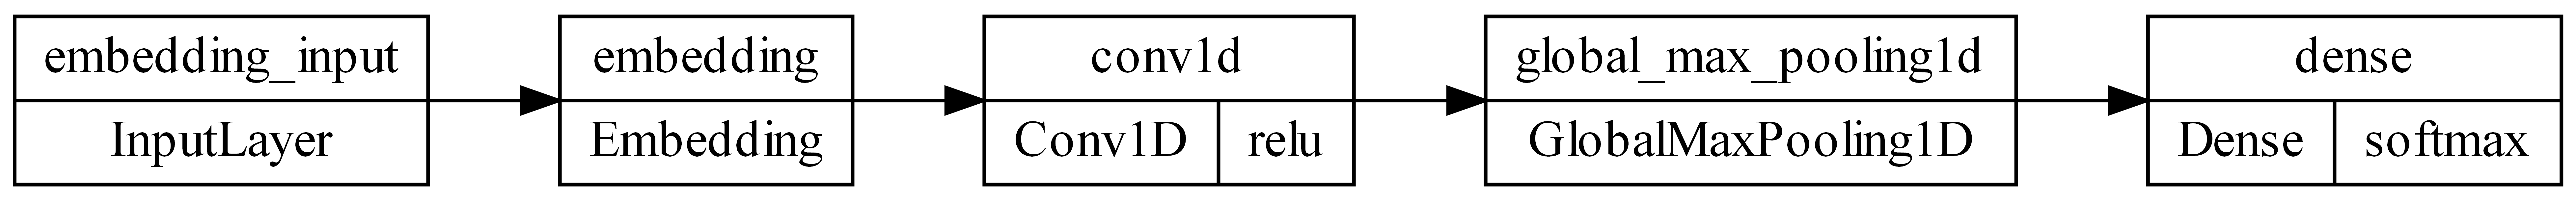

In [23]:
plot_model(model, to_file = 'visualization/non-contextual_model.png', show_shapes = False, show_layer_activations = True, dpi = 800, rankdir = 'LR')